# Cyber Physical Systems Example

Authors: Georgios Bakirtzis [https://bakirtzis.net/](https://bakirtzis.net) and Raul Gonzalez Garcia (raulg@iastate.edu)

The following example is a mechanization from
1. Compositional Cyber-Physical Systems Modeling - [http://dx.doi.org/10.4204/EPTCS.333.9](http://dx.doi.org/10.4204/EPTCS.333.9)
2. Categorical Semantics of Cyber-Physical Systems Theory - [https://doi.org/10.1145/3461669](https://doi.org/10.1145/3461669)

In [1]:
using AlgebraicDynamics
using AlgebraicDynamics.DWDDynam

using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz

using LabelledArrays
using DifferentialEquations
using Plots

We use  functorial semantics to model a cyper-physical system, namely an unmanned aerial vehicle (UAV).
We define a diagram of systems (the composition syntax) that is the architecture of the composition.
Then, we apply behaviors of the individual parts of the system to the architecture. This composition produces
a complete UAV model.

We first have to define our boxes and specify what the inports and outports are.
For example, the sensor box has two inports `:e` and `:s` and one outport `s_prime`.

In [2]:
s = Box(:sensor, [:s, :e], [:s′])
c = Box(:controller, [:d, :s′], [:c])
d = Box(:dynamics, [:c], [:s]);

A wiring diagram has outer inports and outports which define the interface of target system.
Then we add the boxes and wires to the diagram and visualize the result.

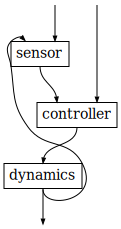

In [3]:
UAV = WiringDiagram([:e,:d], [:s])

sensor     = add_box!(UAV, s)
controller = add_box!(UAV, c)
dynamics   = add_box!(UAV, d)

add_wires!(UAV, [
    # net inputs
    (input_id(UAV), 1) => (sensor, 2),
    (input_id(UAV), 2) => (controller, 2),

    # connections
    (sensor, 1) => (controller, 1),
    (controller, 1) => (dynamics, 1),
    (dynamics, 1) => (sensor, 1),

    # net output
    (dynamics, 1) => (output_id(UAV), 1)
])

to_graphviz(UAV)

Then we assign behaviors to inhabit the boxes.

In [4]:
function 𝗟(𝐖)
    𝐿(u, x, p, t) = LVector( sc = -p.𝓐l * (u[1] - x[1] - x[2]) );
    𝐶(u, x, p, t) = LVector( sl = -p.𝓐c * (u[1] + p.𝓑c*x[1] - x[2]) );
    𝐷(u, x, p, t) = LVector( α = -0.313*u[1] +  56.7*u[2] +  0.232*x[1],
                             q = -0.013*u[1] - 0.426*u[2] + 0.0203*x[1],
                             θ =  56.7*u[2]              );

    u_𝐿(u,p,t) = [ u[1] ];  # outputs sl
    u_𝐶(u,p,t) = [ u[1] ];  # outputs sc
    u_𝐷(u,p,t) = [ u[3] ];  # outputs θ

    return oapply(𝐖,
                  Dict(:sensor     => ContinuousMachine{Float64}(2, 1, 1, 𝐿, u_𝐿),
                       :controller => ContinuousMachine{Float64}(2, 1, 1, 𝐶, u_𝐶),
                       :dynamics   => ContinuousMachine{Float64}(1, 3, 1, 𝐷, u_𝐷)));
end

𝑢ᵤₐᵥ = 𝗟(UAV)

Lastly, we compute and plot the solution.

In [5]:
# initial values
xₒ = LVector( e = 0.01,  # [e, d] -> [θ offset, 𝛿 control input]
              d = 0.05);

uₒ = [0.0, 0, 0, 0, 0]
tspan = (0, 20.0)

params = (𝓐l = 100,  # decay constant of sensor
          𝓐c = 100,  # decay constant of controller
          𝓑c = 0)    # ratio of velocity to reference velocity

prob = ODEProblem(𝑢ᵤₐᵥ, uₒ, xₒ, tspan, params)
solution = solve(prob, alg_hints=[:stiff]);

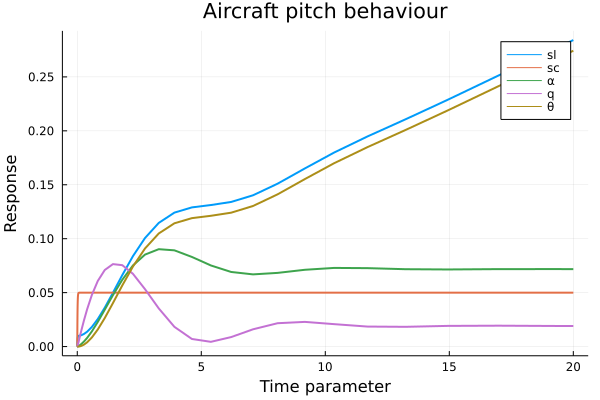

In [6]:
plot(solution.t,        # x values
     [solution[1,:],    # y values [q is amplified]
      solution[2,:],
      solution[3,:],
      solution[4,:] * 1e2,
      solution[5,:]],

    # graph attributes
    label  = ["sl" "sc" "α" "q" "θ"],
    xlabel = "Time parameter",
    ylabel = "Response",
    title  = "Aircraft pitch behaviour",
    lw = 2
)